In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## SGD ##

In [3]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [4]:
## Momentum ##

In [5]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [6]:
## AdaGrad ##

In [7]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)  # 0으로 나누는 것을 막기위해 1e-7을 넣음

In [8]:
## Adam ##

In [9]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

===========iteration:0===========
SGD:2.379942941207131
Momentum:2.282037096448217
AdaGrad:2.14708053862041
Adam:2.2790429065609996
===========iteration:100===========
SGD:1.5847258797075185
Momentum:0.49678451264779583
AdaGrad:0.1973862949576547
Adam:0.31062991713882837
===========iteration:200===========
SGD:0.6869724201753138
Momentum:0.19116053319953868
AdaGrad:0.10551817939707855
Adam:0.10760279973539233
===========iteration:300===========
SGD:0.5860917870142106
Momentum:0.2688946632266957
AdaGrad:0.14659411941837297
Adam:0.20540241032361356
===========iteration:400===========
SGD:0.4648330180990343
Momentum:0.22475778113056682
AdaGrad:0.07896747214599696
Adam:0.13016610172845863
===========iteration:500===========
SGD:0.3368731963971946
Momentum:0.1863108975767252
AdaGrad:0.06129215433588185
Adam:0.09672636926869976
===========iteration:600===========
SGD:0.35844476870742387
Momentum:0.12985211450285167
AdaGrad:0.04729776177739352
Adam:0.09328644405273576
===========iteration:700

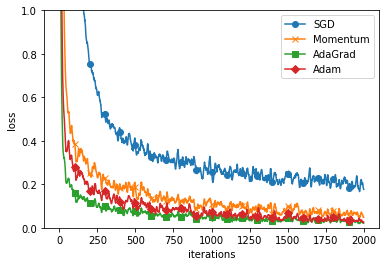

In [10]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from multi_layer_net import MultiLayerNet


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 활성화 값 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)  # Xavier 초기값 사용(앞의 노드 수 분의 1)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

print(activations)

{0: array([[0.33517037, 0.41780813, 0.40789693, ..., 0.59352105, 0.71374235,
        0.76297885],
       [0.12509997, 0.28763642, 0.22458833, ..., 0.68448818, 0.34398367,
        0.09264706],
       [0.26391725, 0.09868007, 0.58046166, ..., 0.56740063, 0.08938841,
        0.33874149],
       ...,
       [0.67433406, 0.45938368, 0.58047063, ..., 0.37791415, 0.35086898,
        0.55116811],
       [0.36343178, 0.32486408, 0.63537643, ..., 0.4653054 , 0.76833842,
        0.42765246],
       [0.64486398, 0.66779952, 0.19620998, ..., 0.18333682, 0.53449755,
        0.47034261]]), 1: array([[0.43156338, 0.53263335, 0.40208941, ..., 0.44215711, 0.50726731,
        0.42378778],
       [0.57976677, 0.48120141, 0.42625308, ..., 0.41739444, 0.51454385,
        0.47906236],
       [0.56144916, 0.57771169, 0.44176155, ..., 0.43195276, 0.57278772,
        0.41652787],
       ...,
       [0.50990484, 0.52508035, 0.4293826 , ..., 0.4382761 , 0.47968997,
        0.35262925],
       [0.48601274, 0.52289

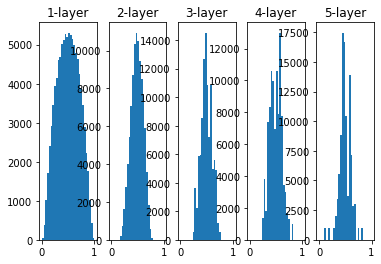

In [13]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

===========iteration:0===========
std=0.01:2.302495597867606
Xavier:2.2976779016863853
He:2.3129352063435933
===========iteration:100===========
std=0.01:2.3021539433005973
Xavier:2.250525505752658
He:1.6742507709997851
===========iteration:200===========
std=0.01:2.3022633246853745
Xavier:2.1133820797298695
He:0.7388400341656874
===========iteration:300===========
std=0.01:2.3015039925107343
Xavier:1.8098691526784625
He:0.516191926989501
===========iteration:400===========
std=0.01:2.2989626570369537
Xavier:1.2383268936493508
He:0.3812084002031851
===========iteration:500===========
std=0.01:2.29964724870613
Xavier:0.8890626769955928
He:0.346249428277673
===========iteration:600===========
std=0.01:2.3005818100816695
Xavier:0.587081662718421
He:0.2671018401945393
===========iteration:700===========
std=0.01:2.299063847031401
Xavier:0.6252360964993556
He:0.31218675585229716
===========iteration:800===========
std=0.01:2.301473074874199
Xavier:0.5341636935933658
He:0.3429049290665064
==

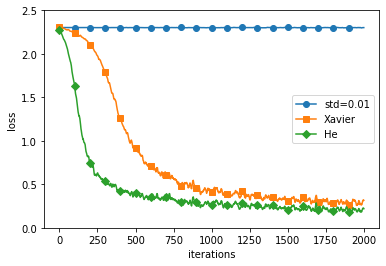

In [14]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from multi_layer_net import MultiLayerNet



# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

In [15]:
 ## 오버피팅 일으켜 보기

In [17]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 데이터 수 줄이기
x_train = x_train[:300]
t_train = t_train[:300]

epoch:0, train acc:0.12, test acc:0.0916
epoch:1, train acc:0.14333333333333334, test acc:0.1128
epoch:2, train acc:0.18333333333333332, test acc:0.1414
epoch:3, train acc:0.22666666666666666, test acc:0.1644
epoch:4, train acc:0.2633333333333333, test acc:0.1871
epoch:5, train acc:0.31666666666666665, test acc:0.2131
epoch:6, train acc:0.33, test acc:0.2156
epoch:7, train acc:0.41, test acc:0.2695
epoch:8, train acc:0.4266666666666667, test acc:0.2924
epoch:9, train acc:0.45, test acc:0.3118
epoch:10, train acc:0.4666666666666667, test acc:0.3138
epoch:11, train acc:0.49666666666666665, test acc:0.3387
epoch:12, train acc:0.5, test acc:0.345
epoch:13, train acc:0.5233333333333333, test acc:0.3753
epoch:14, train acc:0.5933333333333334, test acc:0.3935
epoch:15, train acc:0.6233333333333333, test acc:0.4153
epoch:16, train acc:0.6366666666666667, test acc:0.4282
epoch:17, train acc:0.64, test acc:0.453
epoch:18, train acc:0.67, test acc:0.4476
epoch:19, train acc:0.6733333333333333, te

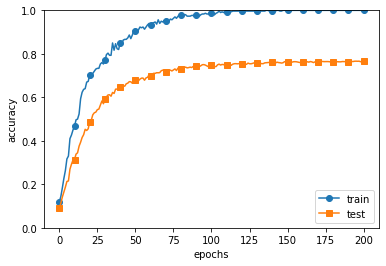

In [18]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
   batch_mask = np.random.choice(train_size, batch_size)
   x_batch = x_train[batch_mask]
   t_batch = t_train[batch_mask]

   grads = network.gradient(x_batch, t_batch)
   optimizer.update(network.params, grads)

   if i % iter_per_epoch == 0:
       train_acc = network.accuracy(x_train, t_train)
       test_acc = network.accuracy(x_test, t_test)
       train_acc_list.append(train_acc)
       test_acc_list.append(test_acc)

       print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

       epoch_cnt += 1
       if epoch_cnt >= max_epochs:
           break

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

epoch:0, train acc:0.043333333333333335, test acc:0.0675
epoch:1, train acc:0.06, test acc:0.0791
epoch:2, train acc:0.09, test acc:0.0949
epoch:3, train acc:0.15333333333333332, test acc:0.119
epoch:4, train acc:0.18666666666666668, test acc:0.1431
epoch:5, train acc:0.2, test acc:0.1611
epoch:6, train acc:0.23333333333333334, test acc:0.1817
epoch:7, train acc:0.27666666666666667, test acc:0.2024
epoch:8, train acc:0.30666666666666664, test acc:0.223
epoch:9, train acc:0.33666666666666667, test acc:0.2436
epoch:10, train acc:0.36, test acc:0.2576
epoch:11, train acc:0.37666666666666665, test acc:0.2699
epoch:12, train acc:0.39666666666666667, test acc:0.2815
epoch:13, train acc:0.41, test acc:0.2933
epoch:14, train acc:0.43, test acc:0.2994
epoch:15, train acc:0.4266666666666667, test acc:0.3072
epoch:16, train acc:0.4266666666666667, test acc:0.3108
epoch:17, train acc:0.44333333333333336, test acc:0.3141
epoch:18, train acc:0.44333333333333336, test acc:0.3148
epoch:19, train acc:0

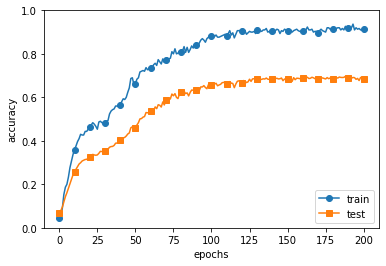

In [21]:
# weight decay（가중치 감소） 설정 =======================

#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
   batch_mask = np.random.choice(train_size, batch_size)
   x_batch = x_train[batch_mask]
   t_batch = t_train[batch_mask]

   grads = network.gradient(x_batch, t_batch)
   optimizer.update(network.params, grads)

   if i % iter_per_epoch == 0:
       train_acc = network.accuracy(x_train, t_train)
       test_acc = network.accuracy(x_test, t_test)
       train_acc_list.append(train_acc)
       test_acc_list.append(test_acc)

       print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

       epoch_cnt += 1
       if epoch_cnt >= max_epochs:
           break

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [22]:
## Dropout 구현

In [24]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [25]:
## Trainer
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.optimizer import *

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


1.9138758127503888
=== epoch:168, train acc:0.45, test acc:0.3807 ===
train loss:1.7489886133544477
train loss:1.8741130077229997
train loss:1.8515443870020312
=== epoch:169, train acc:0.44666666666666666, test acc:0.3798 ===
train loss:1.8425464332368444
train loss:1.8691756482968842
train loss:1.8060784822395037
=== epoch:170, train acc:0.45, test acc:0.3802 ===
train loss:1.8013531839155175
train loss:1.8131327070364887
train loss:1.8069489823302873
=== epoch:171, train acc:0.44666666666666666, test acc:0.3803 ===
train loss:1.879969711043191
train loss:1.732812764872809
train loss:1.8410043200137194
=== epoch:172, train acc:0.44666666666666666, test acc:0.3794 ===
train loss:1.8588495504506142
train loss:1.844501160706491
train loss:1.892346013112398
=== epoch:173, train acc:0.45, test acc:0.3825 ===
train loss:1.7264723807467548
train loss:1.8062749319218891
train loss:1.7640648969809118
=== epoch:174, train acc:0.4533333333333333, test acc:0.3824 ===
train loss:1.779024815903658


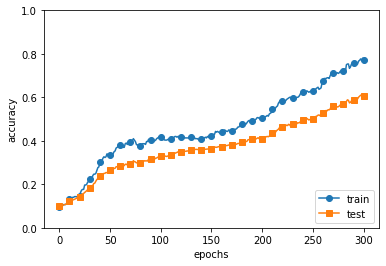

In [28]:
from dataset.mnist import load_mnist
from multi_layer_net_extend import MultiLayerNetExtend

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [29]:
## 검증 데이터셋 만들기

In [32]:
from common.util import *

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련데이터 섞기
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20% 검증 데이터 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [33]:
## 하이퍼파라미터 무작위 추출

In [35]:
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

val acc:0.7 | lr:0.00774086907702824, weight decay:3.038743925140116e-08
val acc:0.15 | lr:0.000153297898311353, weight decay:5.997756440076069e-07
val acc:0.09 | lr:3.3600874753089344e-05, weight decay:7.813359911799453e-05
val acc:0.13 | lr:2.0497699374388037e-05, weight decay:4.182526499418247e-06
val acc:0.22 | lr:3.545956771875724e-05, weight decay:5.65754264610587e-05
val acc:0.7 | lr:0.006033914156448767, weight decay:5.0298669042720386e-05
val acc:0.03 | lr:4.213721818430024e-06, weight decay:9.389884240624531e-07
val acc:0.3 | lr:0.0011080783820201238, weight decay:1.66249341416169e-08
val acc:0.26 | lr:0.0019370256085829713, weight decay:1.7996105443663017e-06
val acc:0.1 | lr:0.00032512689022017716, weight decay:7.094677215308898e-08
val acc:0.07 | lr:7.940566580502259e-06, weight decay:1.4592253224274618e-05
val acc:0.56 | lr:0.003115417168554233, weight decay:1.9428214752699586e-05
val acc:0.07 | lr:1.3943450276665994e-06, weight decay:1.443613378343997e-08
val acc:0.08 | 

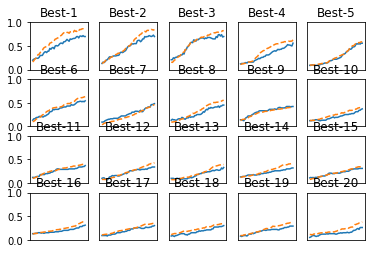

In [39]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset

# 20%를 검증 데이터로 분할

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]


# 훈련데이터 섞기
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20% 검증 데이터 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()